In [1]:
from edge_analyzer import channel_waveform
from iqwaveform import fourier
import numpy as np
import cupy as cp

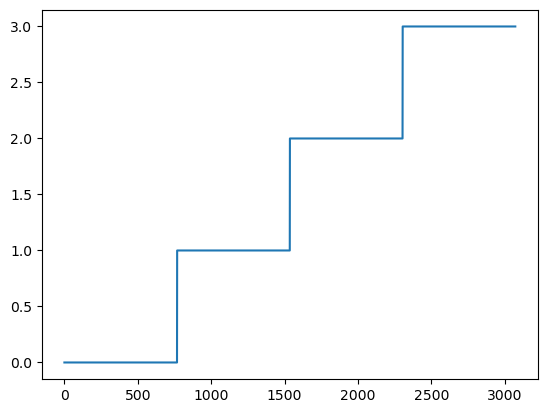

In [2]:
from matplotlib import pyplot as plt

fft_size = 768
x = np.arange(4).repeat(fft_size).astype('complex64')

plt.plot(x.real)

(768, 14)


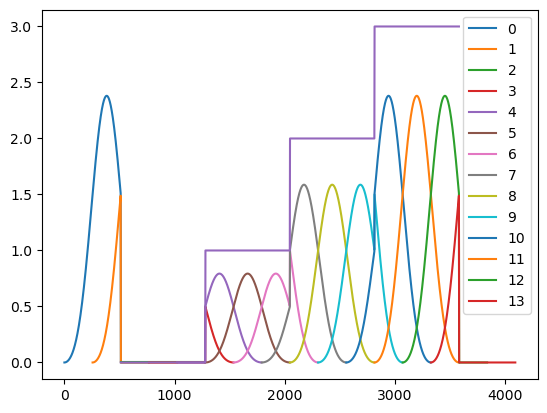

In [3]:
noverlap = 2*fft_size//3
window = fourier._get_window('blackman', fft_size, norm=False)
enbw = channel_waveform.equivalent_noise_bandwidth('blackmanharris', fft_size)

y = fourier._to_overlapping_windows(x, window=window, nperseg=fft_size, noverlap=noverlap).T
print(y.shape)
# y = y.reshape((y.shape[0]*y.shape[1],) + y.shape[2:])

hop_size = fft_size-noverlap
reconstr = np.zeros(x.shape[0] + 2*noverlap)
for i in range(y.shape[1]):
    reconstr[i*hop_size:i*hop_size+fft_size] += y.real[:,i]
    plt.plot(np.arange(y.shape[0]) + i*hop_size, y.real[:,i], label=i)

reconstr[:noverlap] = np.nan
reconstr[-noverlap:] = np.nan

plt.plot(np.arange(reconstr.size), reconstr)
plt.legend()

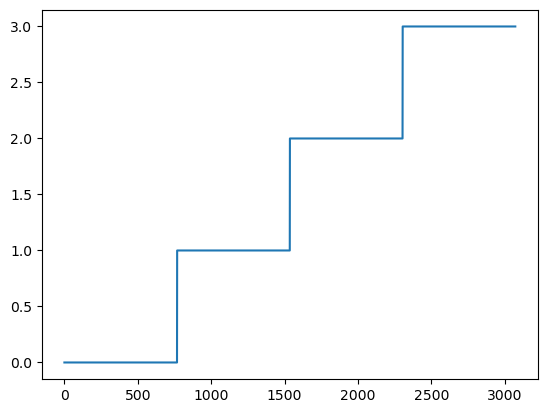

In [4]:
y = fourier._to_overlapping_windows(x, window=window, nperseg=fft_size, noverlap=noverlap)
xr = fourier._from_overlapping_windows(y, noverlap, axis=0)
plt.plot(xr.real)

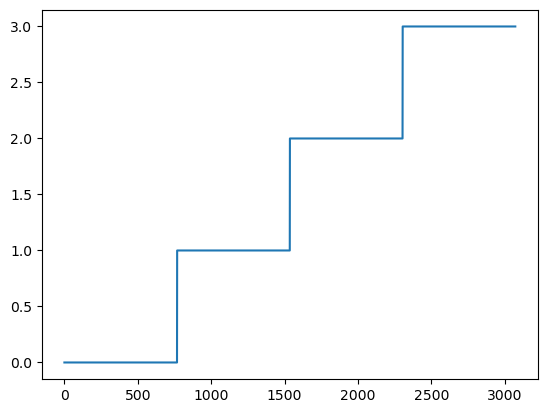

In [5]:
y = fourier._to_overlapping_windows(cp.array(x), window=cp.array(window), nperseg=fft_size, noverlap=noverlap)
xr = fourier._from_overlapping_windows(y, noverlap, axis=0)
plt.plot(xr.real.get())

transform shape:  (14, 768)


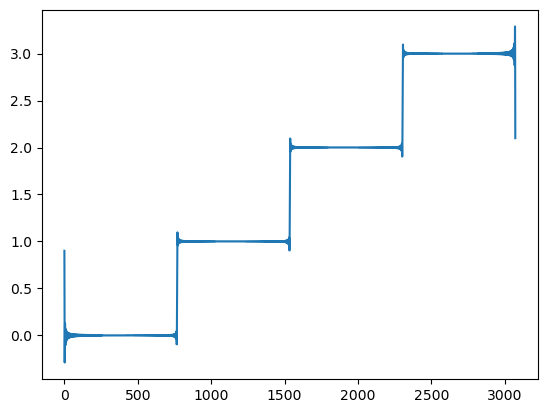

In [6]:
# from cupyx import scipy
import scipy
from iqwaveform import fourier

xr = fourier.ola_filter(cp.array(x), fs=10e6, passband=(-2e6, 2e6), window='blackman', nperseg=768, noverlap=512, axis=0)

plt.plot(xr.real.get())